In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import graphviz as gr

Q1:

In [28]:
np.random.seed(50)
n = 1000
T = np.random.binomial(1, 0.3, n)
X = np.random.normal(15,5,n)
Y = np.random.normal(1 + 3*T + 2*X, 5).astype(int)
data1 = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
data1.to_csv("data1.csv", index=False)

In [29]:
data1

,T,X,Y
0,0,16.656412,38
1,0,19.142785,38
2,0,10.289488,29
3,0,9.198898,22
4,0,9.942119,13
...,...,...,...
995,1,12.900615,29
996,0,10.317704,14
997,0,11.726185,33
998,1,13.049957,36


In [ ]:
(2)DAG

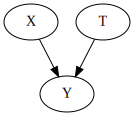

In [30]:
g = gr.Digraph()
g.edge("X", "Y")
g.edge("T", "Y")
g

In [ ]:
(a)Not control for any covariates

In [33]:
class MC_Simulator_a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        X = np.random.normal(15,5,n)
        T = np.random.binomial(1, 0.3, n)
        Y = np.random.normal(1 + 3*T + 2*X, 5).astype(int)
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            a_hat,b_hat = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [34]:
# N=100
mcSim_100 = MC_Simulator_a(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

,N=100,N=1000
bias,3.038245,2.998806
RMSE,11.029844,11.164408
treatment effect,3.038245,2.998806


(b)You control for all the covariates that affect the outcome

In [35]:
class MC_Simulator_b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        X = np.random.normal(15,5,n)
        T = np.random.binomial(1, 0.3, n)
        Y = np.random.normal(1 + 3*T + 2*X, 5).astype(int)
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
        
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            a_hat,b_hat,c_hat = self.estimate_ols_params(Y,T,X)
            y_hat = a_hat + b_hat * T + c_hat * X
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,c,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [36]:
# N=100
mcSim_100 = MC_Simulator_b(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_b(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

C:\Users\18617\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,N=100,N=1000
bias,3.040747,3.003251
RMSE,4.915658,4.996817
treatment effect,3.012591,3.001613


In [ ]:
Real-Life Example

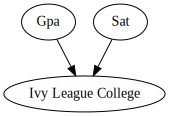

In [39]:
g = gr.Digraph()
g.edge("Gpa", "Ivy League College")
g.edge("Sat", "Ivy League College")
g

 Consider get accepted by Ivy League Colleg is the outcome whcich is T and GPA SCORE AND SAT SCORE will be treament which is 
    X and Y. In this way we can to estimate treatment effectiveness.

In [ ]:
Q2:

In [62]:
np.random.seed(50)
n = 1000
# generate covariate
X = np.random.normal(1,10,n)
# generate treatment
T = np.random.binomial(1, 1/(1+X**4), n)
# generate outcome
Y = np.random.normal(1 + 2*T + 2*X, 5).astype(int)
data2 = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
data2.to_csv("data2.csv", index=False)

In [90]:
data2

,T,X,Y
0,0,-14.603521,-34
1,1,0.690224,11
2,0,-5.209284,-9
3,0,-13.645805,-34
4,0,15.119461,32
...,...,...,...
995,0,-19.855586,-35
996,0,4.670697,14
997,0,-13.079512,-29
998,0,7.339314,22


DAG

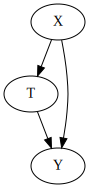

In [63]:
g = gr.Digraph()
g.edge("X", "T")
g.edge("T", "Y")
g.edge("X", "Y")
g

(a)

In [64]:
class MC_Simulator_a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        X = np.random.normal(1,10,n)
        T = np.random.binomial(1, 1/(1+X**4), n)
        Y = np.random.normal(1 + 2*T + 1*X, 5).astype(int)
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            a_hat,b_hat = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [65]:
# N=100
mcSim_100 = MC_Simulator_a(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

,N=100,N=1000
bias,0.691538,0.767949
RMSE,10.688735,10.784875
treatment effect,0.691538,0.767949


(b)

In [66]:
class MC_Simulator_b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        X = np.random.normal(1,10,n)
        T = np.random.binomial(1, 1/(1+X**4), n)
        Y = np.random.normal(1 + 2*T + 1*X, 5).astype(int)
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
        
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            a_hat,b_hat,c_hat = self.estimate_ols_params(Y,T,X)
            y_hat = a_hat + b_hat * T + c_hat * X
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,c,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [67]:
# N=100
mcSim_100 = MC_Simulator_b(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_b(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

C:\Users\18617\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,N=100,N=1000
bias,0.783655,0.770547
RMSE,4.759357,4.838099
treatment effect,1.820789,1.814762


Real-life Example

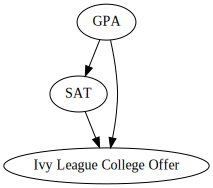

In [101]:
g = gr.Digraph()
g.edge("GPA", "SAT")
g.edge("SAT", "Ivy League College Offer")
g.edge("GPA", "Ivy League College Offer")
g

when we running a regresion on SAT Score on  Ivy League College Offer. let GPA be the confunder,Sat be treament,Ivy League College Offer be outcome.Usually people do well on GPA, they are tend to do well on SAT.(Since they build better fundation) and People with a Higher GPA will have a higher chance to get Ivy Leagu college Offer


Q3

In [84]:
np.random.seed(50)
n = 1000
# generate treatment
T = np.random.binomial(1, 0.8, n)
# generate outcome
Y = np.random.normal(2 + 3*T, 5).astype(int)
# generate covariate
X = np.random.normal(15+np.mean(T)*np.mean(Y),5,n)

data3 = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
data3.to_csv("data3.csv", index=False)

In [91]:
data3

,T,X,Y
0,1,22.027802,6
1,1,17.998490,9
2,1,25.866468,0
3,1,21.327799,0
4,1,11.361761,0
...,...,...,...
995,0,18.443792,0
996,1,11.405732,0
997,1,27.220569,1
998,0,25.186568,0


DAG

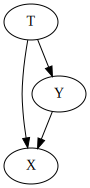

In [85]:
g = gr.Digraph()
g.edge("T", "X")
g.edge("T", "Y")
g.edge("Y", "X")
g

(a)

In [86]:
class MC_Simulator_a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, c, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        c: slope of covariate
        n: sample size
        sigma: error variance
        Y = a+b*T+c*X+e
        """
        T = np.random.binomial(1, 0.8, n)
        Y = np.random.normal(2 + 3*T, 5).astype(int)
        X = np.random.normal(15+np.mean(T)*np.mean(Y),5,n)
        
        return (Y,T,X)  
    
    def estimate_ols_params(self,Y,T,X):
        
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,c,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(a,b,c,n,sigma)
            a_hat,b_hat,c_hat = self.estimate_ols_params(Y,T,X)
            y_hat = a_hat + b_hat * T + c_hat * X
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,c,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,c,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [87]:
# N=100
mcSim_100 = MC_Simulator_a(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_a(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

C:\Users\18617\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,N=100,N=1000
bias,2.811045,2.813150
RMSE,4.663928,4.741671
treatment effect,2.812060,2.813128


(b)

In [88]:
class MC_Simulator_b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, a, b, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        T = np.random.binomial(1, 0.8, n)
        Y = np.random.normal(2 + 3*T, 5).astype(int)
        X = np.random.normal(15+np.mean(T)*np.mean(Y),5,n)
        
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,a,b,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(a,b,n,sigma)
            a_hat,b_hat = self.estimate_ols_params(Y,T)
            y_hat = a_hat + b_hat * T
            treatment_effect = treatment_effect + [b_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,a,b,n,sigma):
        bias, RMSE, treatment_effect = self.run_mc_simulation(a,b,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [89]:
# N=100
mcSim_100 = MC_Simulator_b(10000)
res_100 = mcSim_100.summarize_mc_simulation(1,1,100,1)
# N=1000
mcSim_1000 = MC_Simulator_b(10000)
res_1000 = mcSim_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

,N=100,N=1000
bias,2.804110,2.813112
RMSE,4.689226,4.743157
treatment effect,2.804110,2.813112


Real-life Example

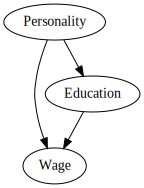

In [96]:
g = gr.Digraph()
g.edge("Personality", "Wage")
g.edge("Personality", "Education")
g.edge("Education", "Wage")
g

In [ ]:
when we running a regresion on education on  wage. Personality will be the selection bias,education be treament,wgae be outcome. 
Some people are more competitive and motivated, and will put more effort into improving their grades to get a better education and salary
However, there  is some people believe that the meaning of life does not lie in this, and they have a more casual personality.
They are happier to focus on other things.